Setup and Fetch

In [2]:
!pip install ucimlrepo

import pandas as pd
from ucimlrepo import fetch_ucirepo

# Fetch the dataset (ID 17 is for Breast Cancer Wisconsin Diagnostic)
dataset = fetch_ucirepo(id=17)

# Load features and targets into DataFrames
X = dataset.data.features
y = dataset.data.targets

# Combine them for easier analysis
df = pd.concat([X, y], axis=1)
print(f"Data loaded successfully. Shape: {df.shape}")

Data loaded successfully. Shape: (569, 31)


Cleaning and Analysis

In [4]:

print(f"Missing Values: {df.isnull().sum().sum()}")
print(f"Duplicates: {df.duplicated().sum()}")

# Quick glimpse of the classes (Malignant vs Benign)
print("\nDiagnosis Counts:")
print(df['Diagnosis'].value_counts())

Missing Values: 0
Duplicates: 0

Diagnosis Counts:
Diagnosis
B    357
M    212
Name: count, dtype: int64


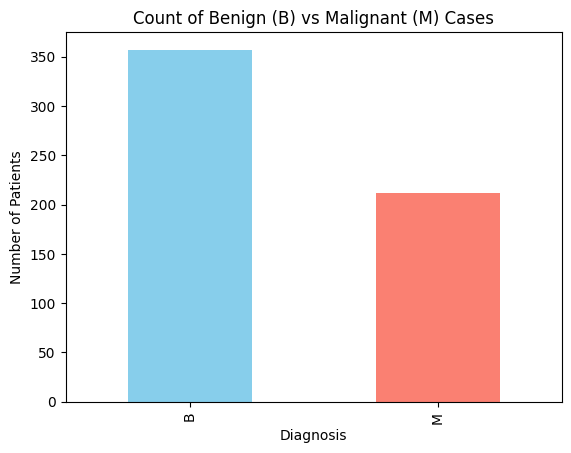

In [5]:
import matplotlib.pyplot as plt

# Plot the counts
df['Diagnosis'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Benign (B) vs Malignant (M) Cases')
plt.xlabel('Diagnosis')
plt.ylabel('Number of Patients')
plt.show()

In [8]:
# STEP 1: Look at the types
print("--- DATA TYPES ---")
print(df.dtypes.value_counts()) # Summary of types
print("\nDetailed Info:")
df.info()

--- DATA TYPES ---
float64    30
object      1
Name: count, dtype: int64

Detailed Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   radius1             569 non-null    float64
 1   texture1            569 non-null    float64
 2   perimeter1          569 non-null    float64
 3   area1               569 non-null    float64
 4   smoothness1         569 non-null    float64
 5   compactness1        569 non-null    float64
 6   concavity1          569 non-null    float64
 7   concave_points1     569 non-null    float64
 8   symmetry1           569 non-null    float64
 9   fractal_dimension1  569 non-null    float64
 10  radius2             569 non-null    float64
 11  texture2            569 non-null    float64
 12  perimeter2          569 non-null    float64
 13  area2               569 non-null    float64
 14  smoothness2      

In [9]:
# STEP 2: Look at the ranges
print("--- SUMMARY STATISTICS ---")
# We look at Mean, Min, and Max for a few sample columns
stats = df.describe().T  # .T flips it for easier reading
print(stats[['mean', 'min', 'max']].head(10))

--- SUMMARY STATISTICS ---
                          mean        min         max
radius1              14.127292    6.98100    28.11000
texture1             19.289649    9.71000    39.28000
perimeter1           91.969033   43.79000   188.50000
area1               654.889104  143.50000  2501.00000
smoothness1           0.096360    0.05263     0.16340
compactness1          0.104341    0.01938     0.34540
concavity1            0.088799    0.00000     0.42680
concave_points1       0.048919    0.00000     0.20120
symmetry1             0.181162    0.10600     0.30400
fractal_dimension1    0.062798    0.04996     0.09744


Encoding the Target (y)

In [11]:
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder
le = LabelEncoder()

# y.values.ravel() flattens the 2D column into a 1D array for the encoder
y_encoded = le.fit_transform(y.values.ravel())

print("First 5 Encoded Labels (1=M, 0=B):", y_encoded[:5])

First 5 Encoded Labels (1=M, 0=B): [1 1 1 1 1]


Splitting the Data

In [12]:
from sklearn.model_selection import train_test_split

# We use an 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 455
Testing samples: 114


 Scaling the Features (X)

In [13]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# 1. Learn the mean/std from training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# 2. Apply the same scaling to the test data (without re-learning)
X_test_scaled = scaler.transform(X_test)

# Quick check: The mean of the first feature should now be approximately 0
print(f"Scaled Mean (Feature 1): {X_train_scaled[:, 0].mean():.2f}")

Scaled Mean (Feature 1): -0.00


Create and Train the Model

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
# n_estimators=100 means we are using 100 individual decision trees
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train (Fit) the model
model.fit(X_train_scaled, y_train)

print("Model training complete.")

Model training complete.


Evaluate the Model

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")

# Detailed Report (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 96.49%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



Visualizing the "Check" (Confusion Matrix)

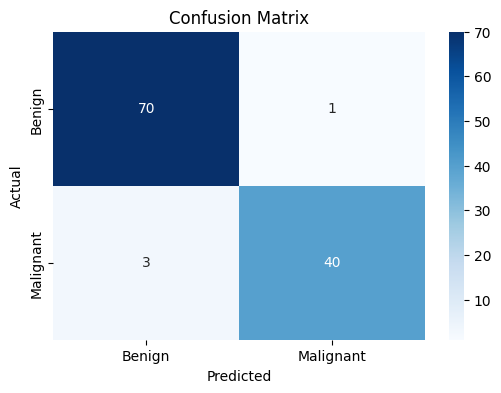

In [16]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Save the Model for Future Use

In [17]:
import joblib

# Save the model
joblib.dump(model, 'breast_cancer_classifier.pkl')

# IMPORTANT: Save the scaler too!
# You must scale new patient data the same way you scaled the training data.
joblib.dump(scaler, 'diagnosis_scaler.pkl')

print("Model and Scaler saved to your Colab files!")

Model and Scaler saved to your Colab files!
